In [1]:
# ПРОЕКТ: Классификация спам-писем с использованием машинного обучения

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("ПРОЕКТ: Классификация спам-писем")

ПРОЕКТ: Классификация спам-писем


# 1. ПРЕЗЕНТАЦИЯ ПРОЕКТА

## Название проекта
**Разработка интеллектуальной системы автоматической фильтрации спама в Gmail на основе анализа текста писем с использованием методов машинного обучения.**

## Цель проекта
Разработать модель машинного обучения, которая с точностью выше 95% классифицирует входящие электронные письма как спам или не-спам (ham), автоматизируя процесс фильтрации нежелательной почты.

## Задачи проекта
1. Загрузить и изучить датасет электронных писем
2. Провести разведочный анализ данных (EDA) и визуализацию
3. Выполнить препроцессинг текстовых данных (очистка, токенизация, векторизация)
4. Обучить несколько моделей классификации (Логистическая регрессия, Random Forest, XGBoost)
5. Сравнить модели по ключевым метрикам (Accuracy, Precision, Recall, F1-Score, ROC AUC)
6. Выбрать лучшую модель и проанализировать важность признаков
7. Визуализировать результаты (Confusion Matrix, ROC-кривая)

## Актуальность
Фильтрация спама критически важна для:
- **Безопасности пользователей**: защита от фишинга и мошенничества
- **Производительности**: экономия времени на обработке нежелательной почты
- **Экономики**: снижение затрат на хранение и обработку спама (миллиарды долларов ежегодно)
- **UX**: улучшение пользовательского опыта при работе с почтой

Современные почтовые системы обрабатывают миллиарды писем ежедневно, и автоматическая классификация спама является неотъемлемой частью инфраструктуры электронной почты.


# 2. ДАТАСЕТ (Dataset)

## Источник данных
Датасет `emails.csv` содержит коллекцию электронных писем с метками спам/не-спам.

## Описание набора данных

In [2]:
# Загрузка датасета
df = pd.read_csv('data/emails.csv')

print("ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nКолонки: {df.columns.tolist()}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПропущенные значения:\n{df.isnull().sum()}")
print(f"\nДубликаты: {df.duplicated().sum()}")

# Распределение классов
print("РАСПРЕДЕЛЕНИЕ КЛАССОВ")
print(df['spam'].value_counts())
print(f"\nПроцентное соотношение:")
print(df['spam'].value_counts(normalize=True) * 100)

# Примеры данных
print("ПРИМЕРЫ ДАННЫХ")
print("\nПервые 3 записи:")
print(df.head(3))


ИНФОРМАЦИЯ О ДАТАСЕТЕ

Размер датасета: 5728 строк, 2 столбцов

Колонки: ['text', 'spam']

Типы данных:
text    object
spam     int64
dtype: object

Пропущенные значения:
text    0
spam    0
dtype: int64

Дубликаты: 33
РАСПРЕДЕЛЕНИЕ КЛАССОВ
spam
0    4360
1    1368
Name: count, dtype: int64

Процентное соотношение:
spam
0    76.117318
1    23.882682
Name: proportion, dtype: float64
ПРИМЕРЫ ДАННЫХ

Первые 3 записи:
                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1


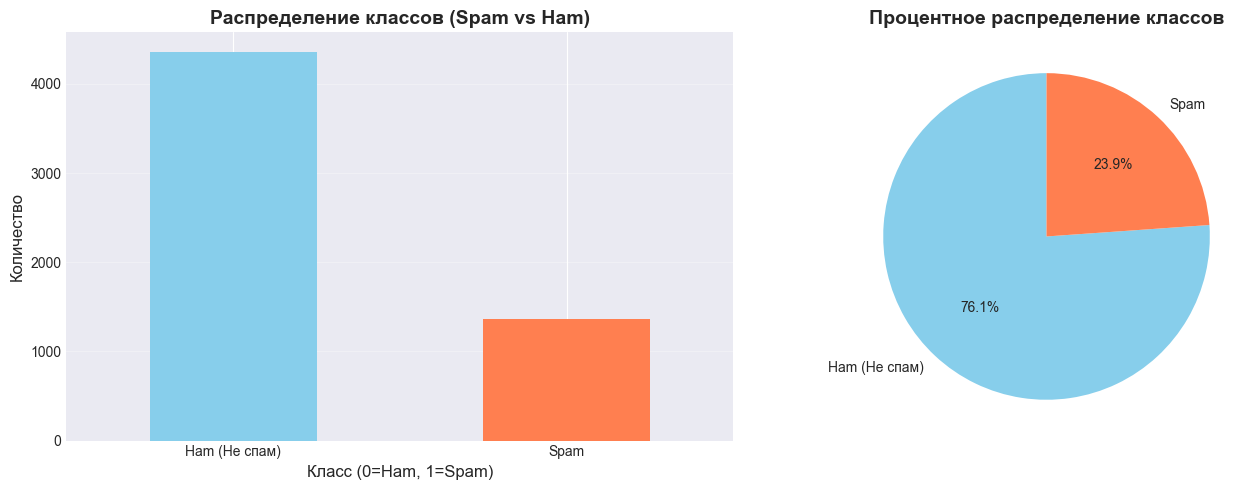


Вывод: Датасет содержит 5728 писем, из которых:
  - 4360 (76.1%) - Ham (не спам)
  - 1368 (23.9%) - Spam

Датасет несбалансирован, что потребует внимания при обучении моделей.


In [3]:
# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Столбчатая диаграмма
df['spam'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('Распределение классов (Spam vs Ham)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Класс (0=Ham, 1=Spam)', fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)
axes[0].set_xticklabels(['Ham (Не спам)', 'Spam'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Круговая диаграмма
df['spam'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                labels=['Ham (Не спам)', 'Spam'],
                                colors=['skyblue', 'coral'], startangle=90)
axes[1].set_title('Процентное распределение классов', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nВывод: Датасет содержит {df.shape[0]} писем, из которых:")
print(f"  - {df[df['spam']==0].shape[0]} ({df[df['spam']==0].shape[0]/df.shape[0]*100:.1f}%) - Ham (не спам)")
print(f"  - {df[df['spam']==1].shape[0]} ({df[df['spam']==1].shape[0]/df.shape[0]*100:.1f}%) - Spam")
print(f"\nДатасет несбалансирован, что потребует внимания при обучении моделей.")


# 3. ПРЕПРОЦЕССИНГ (Preprocessing) И EDA

## 3.1 Анализ длины текстов


In [4]:
# Анализ длины текстов
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("СТАТИСТИКА ПО ДЛИНЕ ТЕКСТОВ")
print("\nОбщая статистика:")
print(df[['text_length', 'word_count']].describe())

print("\n\nСтатистика по классам:")
print(df.groupby('spam')[['text_length', 'word_count']].describe())


СТАТИСТИКА ПО ДЛИНЕ ТЕКСТОВ

Общая статистика:
        text_length   word_count
count   5728.000000  5728.000000
mean    1556.768680   326.848638
std     2042.649812   418.777435
min       13.000000     2.000000
25%      508.750000   101.000000
50%      979.000000   210.000000
75%     1894.250000   401.000000
max    43952.000000  8477.000000


Статистика по классам:
     text_length                                                           \
           count         mean          std   min     25%     50%      75%   
spam                                                                        
0         4360.0  1631.918119  1959.664549  13.0  577.75  1122.0  2037.25   
1         1368.0  1317.257310  2271.372893  18.0  401.50   693.5  1250.25   

              word_count                                                     \
          max      count        mean         std  min    25%    50%     75%   
spam                                                                          
0     43

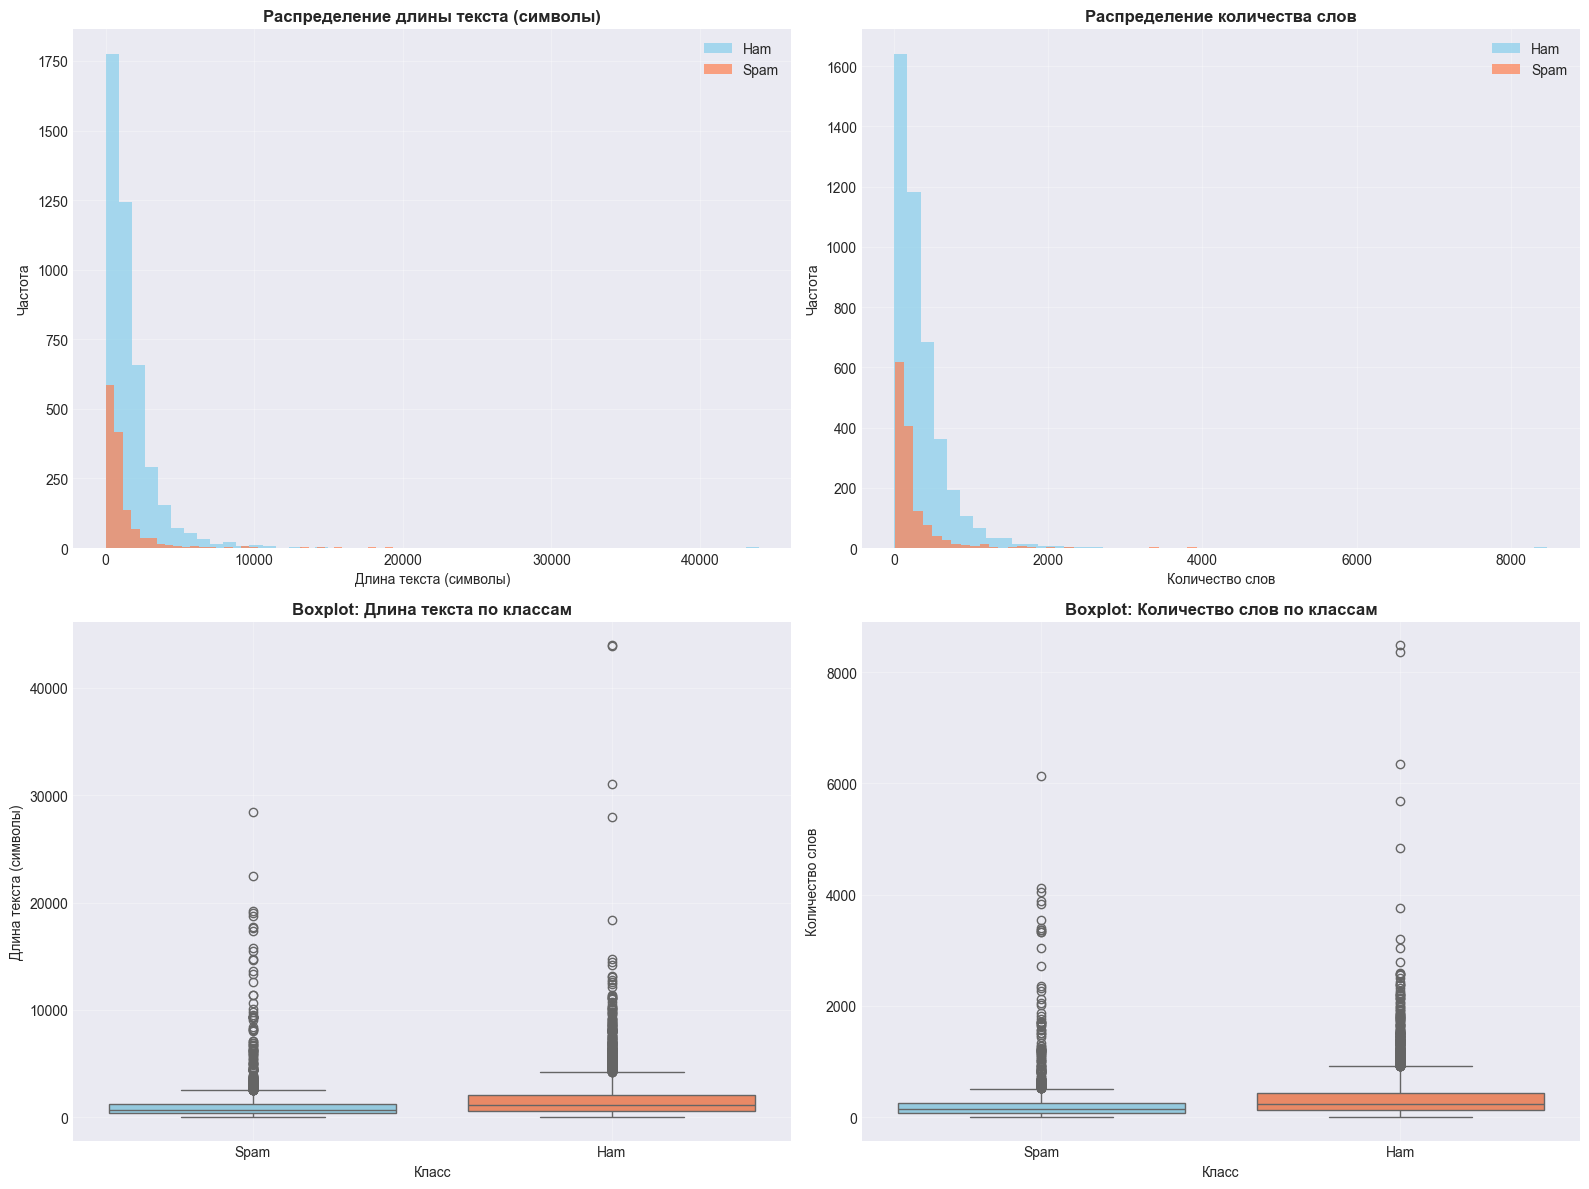

In [5]:
# Визуализация длины текстов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Распределение длины текста
axes[0, 0].hist(df[df['spam']==0]['text_length'], bins=50, alpha=0.7, label='Ham', color='skyblue')
axes[0, 0].hist(df[df['spam']==1]['text_length'], bins=50, alpha=0.7, label='Spam', color='coral')
axes[0, 0].set_title('Распределение длины текста (символы)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Длина текста (символы)')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Распределение количества слов
axes[0, 1].hist(df[df['spam']==0]['word_count'], bins=50, alpha=0.7, label='Ham', color='skyblue')
axes[0, 1].hist(df[df['spam']==1]['word_count'], bins=50, alpha=0.7, label='Spam', color='coral')
axes[0, 1].set_title('Распределение количества слов', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Количество слов')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Boxplot длины текста
df_box = pd.melt(df, id_vars=['spam'], value_vars=['text_length'], 
                 var_name='metric', value_name='value')
df_box['spam_label'] = df_box['spam'].map({0: 'Ham', 1: 'Spam'})
sns.boxplot(data=df_box, x='spam_label', y='value', ax=axes[1, 0], palette=['skyblue', 'coral'])
axes[1, 0].set_title('Boxplot: Длина текста по классам', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Класс')
axes[1, 0].set_ylabel('Длина текста (символы)')
axes[1, 0].grid(alpha=0.3)

# Boxplot количества слов
df_box2 = pd.melt(df, id_vars=['spam'], value_vars=['word_count'], 
                  var_name='metric', value_name='value')
df_box2['spam_label'] = df_box2['spam'].map({0: 'Ham', 1: 'Spam'})
sns.boxplot(data=df_box2, x='spam_label', y='value', ax=axes[1, 1], palette=['skyblue', 'coral'])
axes[1, 1].set_title('Boxplot: Количество слов по классам', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Класс')
axes[1, 1].set_ylabel('Количество слов')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 3.2 Очистка и препроцессинг текстовых данных


In [6]:
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def clean_text(text):
    """
    Очистка текста: удаление лишних символов, приведение к нижнему регистру
    """
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Удаление email адресов
    text = re.sub(r'\S+@\S+', '', text)
    
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)
    
    # Удаление пунктуации
    # text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text.strip()

# Применяем очистку
print("Очистка текстов...")
df['text_cleaned'] = df['text'].apply(clean_text)

print("Примеры очищенных текстов:")
print("\nОригинал (первые 200 символов):")
print(df['text'].iloc[0][:200])
print("\nОчищенный (первые 200 символов):")
print(df['text_cleaned'].iloc[0][:200])


Очистка текстов...
Примеры очищенных текстов:

Оригинал (первые 200 символов):
Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , st

Очищенный (первые 200 символов):
subject: naturally irresistible your corporate identity lt is really hard to recollect a company : the market is full of suqgestions and the information isoverwhelminq ; but a good catchy logo , styli


## 3.3 Векторизация текста (TF-IDF)


In [7]:
# TF-IDF векторизация
# Используем параметры, которые хорошо работают для спам-детекции
vectorizer = TfidfVectorizer(
    max_features=5000,        # Ограничиваем количество признаков для производительности
    min_df=2,                  # Минимальная частота слова в документах
    max_df=0.95,               # Максимальная частота слова (игнорируем слишком частые)
    ngram_range=(1, 2),        # Используем униграммы и биграммы
    stop_words='english'       # Удаляем стоп-слова
)

print("Векторизация текстов с помощью TF-IDF...")
X = vectorizer.fit_transform(df['text_cleaned'])
y = df['spam'].values

print(f"\nРазмерность матрицы признаков: {X.shape}")
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество образцов: {X.shape[0]}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"\nРаспределение классов в обучающей выборке:")
print(f"  Ham: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Spam: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")


Векторизация текстов с помощью TF-IDF...

Размерность матрицы признаков: (5728, 5000)
Количество признаков: 5000
Количество образцов: 5728

Размер обучающей выборки: 4582
Размер тестовой выборки: 1146

Распределение классов в обучающей выборке:
  Ham: 3488 (76.1%)
  Spam: 1094 (23.9%)


# 4. АРХИТЕКТУРА МОДЕЛЕЙ

## Выбранные модели

Для задачи классификации спама мы обучим следующие модели:

1. **Логистическая регрессия** - базовая линейная модель, быстрая и интерпретируемая
2. **Random Forest** - ансамблевая модель на основе деревьев решений, хорошо работает с текстовыми данными
3. **XGBoost** - градиентный бустинг, часто показывает лучшие результаты на структурированных данных

**Почему эти модели?**
- Логистическая регрессия: простая, быстрая, хорошая базовая модель для текстовых данных
- Random Forest: устойчива к переобучению, хорошо обрабатывает нелинейные зависимости
- XGBoost: мощный алгоритм, часто показывает лучшие результаты в соревнованиях

Для текстовых данных эти модели работают эффективно после TF-IDF векторизации.


# 5. ОБУЧЕНИЕ МОДЕЛЕЙ

## 5.1 Логистическая регрессия


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score
import time

# Логистическая регрессия
print("ОБУЧЕНИЕ: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")

start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)
lr_train_time = time.time() - start_time

# Предсказания
lr_y_pred = lr_model.predict(X_test)
lr_y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Метрики
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred)
lr_recall = recall_score(y_test, lr_y_pred)
lr_f1 = f1_score(y_test, lr_y_pred)
lr_roc_auc = roc_auc_score(y_test, lr_y_pred_proba)

print(f"\nВремя обучения: {lr_train_time:.2f} секунд")
print(f"\nМЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"  Accuracy:  {lr_accuracy:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall:    {lr_recall:.4f}")
print(f"  F1-Score:  {lr_f1:.4f}")
print(f"  ROC AUC:   {lr_roc_auc:.4f}")

# Кросс-валидация
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nКросс-валидация (5-fold) Accuracy: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std()*2:.4f})")


ОБУЧЕНИЕ: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Время обучения: 0.02 секунд

МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:
  Accuracy:  0.9869
  Precision: 0.9544
  Recall:    0.9927
  F1-Score:  0.9732
  ROC AUC:   0.9990

Кросс-валидация (5-fold) Accuracy: 0.9865 (+/- 0.0049)


## 5.2 Random Forest


In [9]:
from sklearn.ensemble import RandomForestClassifier

print("ОБУЧЕНИЕ: RANDOM FOREST")

start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_time

# Предсказания
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Метрики
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba)

print(f"\nВремя обучения: {rf_train_time:.2f} секунд")
print(f"\nМЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"  Accuracy:  {rf_accuracy:.4f}")
print(f"  Precision: {rf_precision:.4f}")
print(f"  Recall:    {rf_recall:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")
print(f"  ROC AUC:   {rf_roc_auc:.4f}")

# Кросс-валидация
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nКросс-валидация (5-fold) Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std()*2:.4f})")


ОБУЧЕНИЕ: RANDOM FOREST

Время обучения: 0.11 секунд

МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:
  Accuracy:  0.9459
  Precision: 0.8174
  Recall:    0.9964
  F1-Score:  0.8980
  ROC AUC:   0.9954

Кросс-валидация (5-fold) Accuracy: 0.9478 (+/- 0.0148)


## 5.3 XGBoost


In [10]:
from xgboost import XGBClassifier

print("ОБУЧЕНИЕ: XGBOOST")

start_time = time.time()
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # Балансировка классов
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time

# Предсказания
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Метрики
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)

print(f"\nВремя обучения: {xgb_train_time:.2f} секунд")
print(f"\nМЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"  Accuracy:  {xgb_accuracy:.4f}")
print(f"  Precision: {xgb_precision:.4f}")
print(f"  Recall:    {xgb_recall:.4f}")
print(f"  F1-Score:  {xgb_f1:.4f}")
print(f"  ROC AUC:   {xgb_roc_auc:.4f}")

# Кросс-валидация
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nКросс-валидация (5-fold) Accuracy: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std()*2:.4f})")


ОБУЧЕНИЕ: XGBOOST

Время обучения: 1.55 секунд

МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:
  Accuracy:  0.9703
  Precision: 0.8896
  Recall:    1.0000
  F1-Score:  0.9416
  ROC AUC:   0.9966

Кросс-валидация (5-fold) Accuracy: 0.9727 (+/- 0.0100)


# 6. СРАВНЕНИЕ МОДЕЛЕЙ

## 6.1 Сводная таблица результатов


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                 Модель  Accuracy  Precision   Recall  F1-Score  ROC AUC  Время обучения (сек)
Логистическая регрессия  0.986911   0.954386 0.992701  0.973166 0.998962              0.022191
          Random Forest  0.945899   0.817365 0.996350  0.898026 0.995436              0.113786
                XGBoost  0.970332   0.889610 1.000000  0.941581 0.996648              1.549883


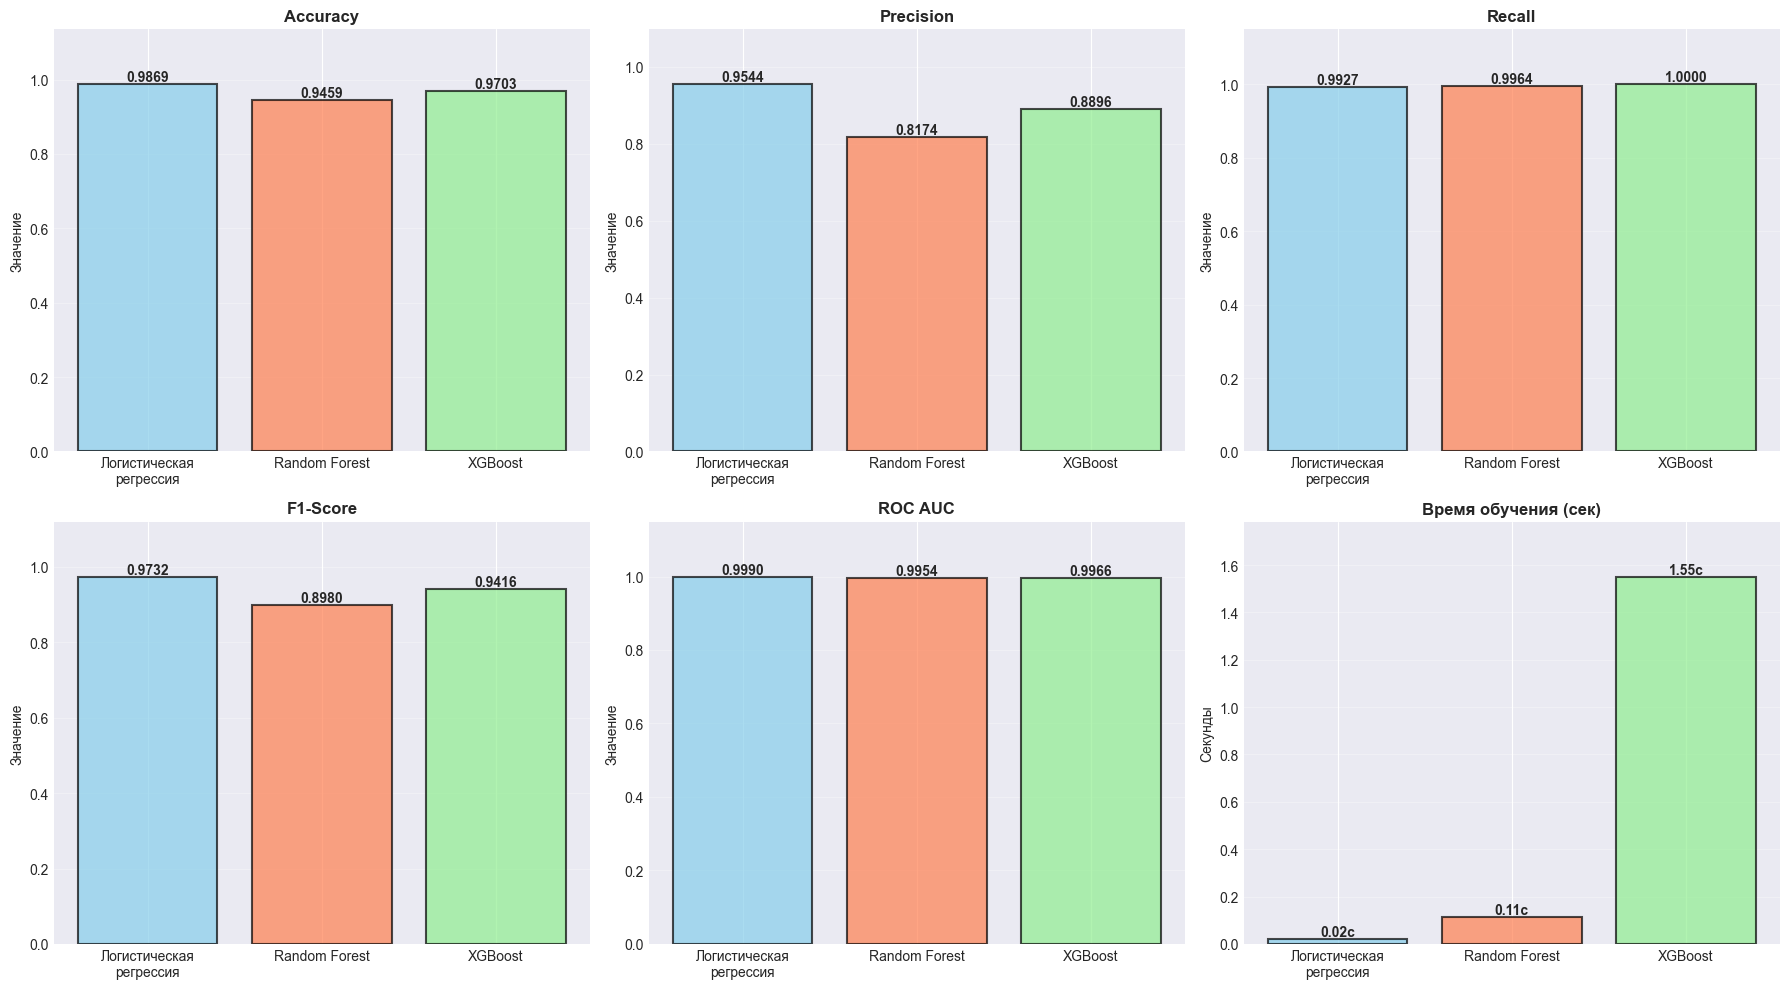

ЛУЧШАЯ МОДЕЛЬ: Логистическая регрессия
  F1-Score: 0.9732
  Accuracy: 0.9869
  ROC AUC:  0.9990


In [11]:
# Создание сводной таблицы результатов
results_df = pd.DataFrame({
    'Модель': ['Логистическая регрессия', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy],
    'Precision': [lr_precision, rf_precision, xgb_precision],
    'Recall': [lr_recall, rf_recall, xgb_recall],
    'F1-Score': [lr_f1, rf_f1, xgb_f1],
    'ROC AUC': [lr_roc_auc, rf_roc_auc, xgb_roc_auc],
    'Время обучения (сек)': [lr_train_time, rf_train_time, xgb_train_time]
})

print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print(results_df.to_string(index=False))

# Визуализация сравнения метрик
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Время обучения (сек)']
models = ['Логистическая\nрегрессия', 'Random Forest', 'XGBoost']
colors = ['skyblue', 'coral', 'lightgreen']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = results_df[metric].values
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}' if metric != 'Время обучения (сек)' else f'{value:.2f}с',
                ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Значение' if metric != 'Время обучения (сек)' else 'Секунды')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.show()

# Определение лучшей модели
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Модель']
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"  F1-Score: {results_df.loc[results_df['F1-Score'].idxmax(), 'F1-Score']:.4f}")
print(f"  Accuracy: {results_df.loc[results_df['F1-Score'].idxmax(), 'Accuracy']:.4f}")
print(f"  ROC AUC:  {results_df.loc[results_df['F1-Score'].idxmax(), 'ROC AUC']:.4f}")


## 6.2 Матрицы ошибок (Confusion Matrix)


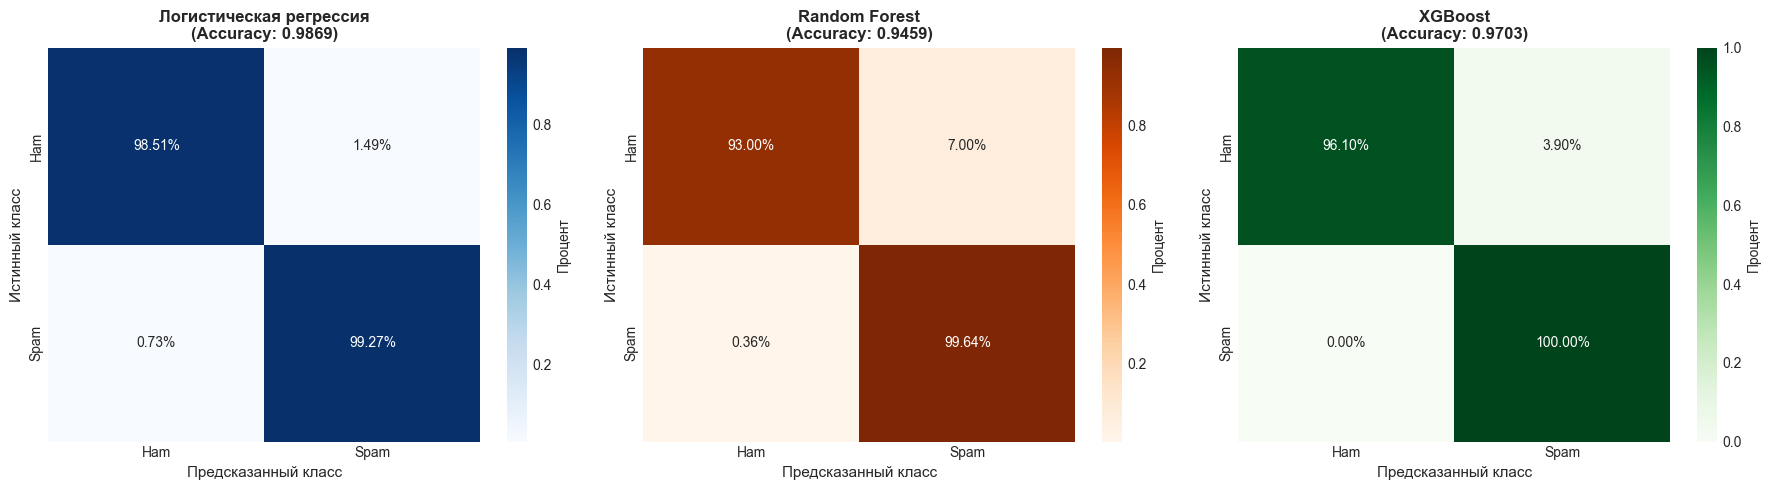

МАТРИЦЫ ОШИБОК (Confusion Matrix)

Логистическая регрессия:
  True Negatives (Ham→Ham):  859
  False Positives (Ham→Spam): 13
  False Negatives (Spam→Ham): 2
  True Positives (Spam→Spam):  272

Random Forest:
  True Negatives (Ham→Ham):  811
  False Positives (Ham→Spam): 61
  False Negatives (Spam→Ham): 1
  True Positives (Spam→Spam):  273

XGBoost:
  True Negatives (Ham→Ham):  838
  False Positives (Ham→Spam): 34
  False Negatives (Spam→Ham): 0
  True Positives (Spam→Spam):  274


In [12]:
# Матрицы ошибок для всех моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    (lr_y_pred, 'Логистическая регрессия', 'Blues'),
    (rf_y_pred, 'Random Forest', 'Oranges'),
    (xgb_y_pred, 'XGBoost', 'Greens')
]

for idx, (y_pred, model_name, cmap) in enumerate(models_data):
    cm = confusion_matrix(y_test, y_pred)
    
    # Нормализованная матрица ошибок
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap=cmap, 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
                ax=axes[idx], cbar_kws={'label': 'Процент'})
    axes[idx].set_title(f'{model_name}\n(Accuracy: {accuracy_score(y_test, y_pred):.4f})', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Истинный класс', fontsize=11)
    axes[idx].set_xlabel('Предсказанный класс', fontsize=11)

plt.tight_layout()
plt.show()

# Вывод числовых значений матриц ошибок
print("МАТРИЦЫ ОШИБОК (Confusion Matrix)")

for y_pred, model_name, _ in models_data:
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{model_name}:")
    print(f"  True Negatives (Ham→Ham):  {cm[0,0]}")
    print(f"  False Positives (Ham→Spam): {cm[0,1]}")
    print(f"  False Negatives (Spam→Ham): {cm[1,0]}")
    print(f"  True Positives (Spam→Spam):  {cm[1,1]}")


## 6.3 ROC-кривые и AUC


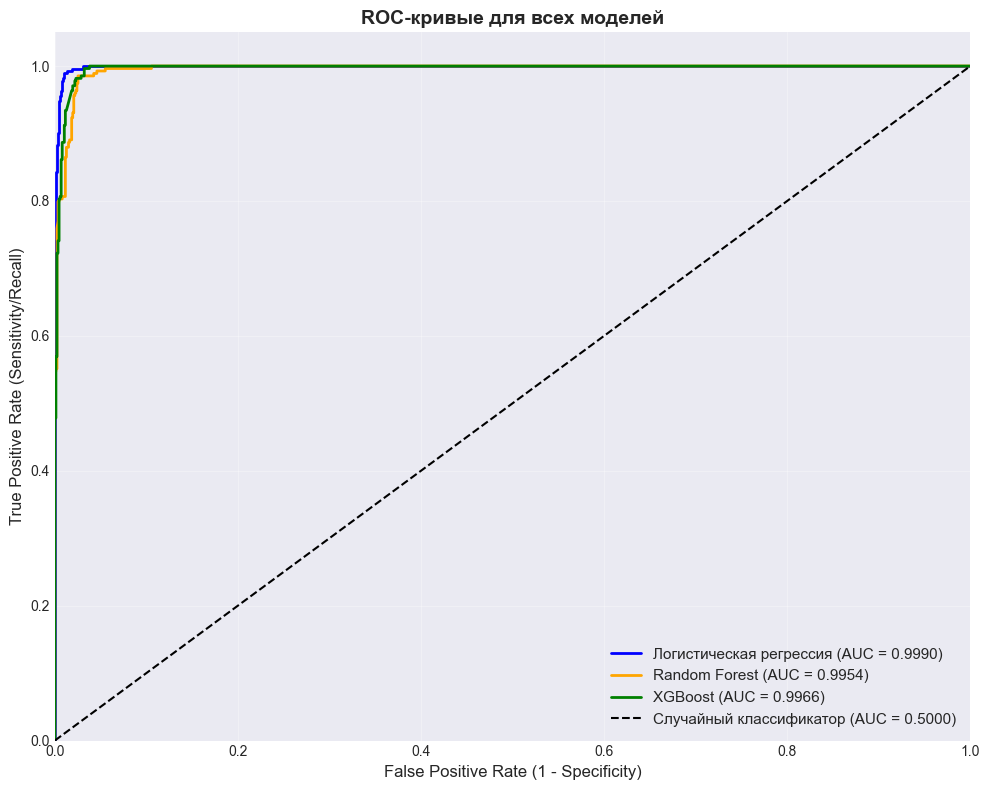

ИНТЕРПРЕТАЦИЯ ROC AUC:
  AUC = 1.0: Идеальный классификатор
  AUC > 0.9: Отличный классификатор
  AUC > 0.8: Хороший классификатор
  AUC = 0.5: Случайный классификатор
  AUC < 0.5: Хуже случайного


In [13]:
# ROC-кривые для всех моделей
fig, ax = plt.subplots(figsize=(10, 8))

models_roc = [
    (lr_y_pred_proba, lr_roc_auc, 'Логистическая регрессия', 'blue'),
    (rf_y_pred_proba, rf_roc_auc, 'Random Forest', 'orange'),
    (xgb_y_pred_proba, xgb_roc_auc, 'XGBoost', 'green')
]

for y_pred_proba, roc_auc, model_name, color in models_roc:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', 
            linewidth=2, color=color)

# Диагональная линия (случайный классификатор)
ax.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор (AUC = 0.5000)', linewidth=1.5)

ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
ax.set_title('ROC-кривые для всех моделей', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print("ИНТЕРПРЕТАЦИЯ ROC AUC:")
print("  AUC = 1.0: Идеальный классификатор")
print("  AUC > 0.9: Отличный классификатор")
print("  AUC > 0.8: Хороший классификатор")
print("  AUC = 0.5: Случайный классификатор")
print("  AUC < 0.5: Хуже случайного")


## 6.4 Важность признаков (Feature Importance)

Для Random Forest и XGBoost можно проанализировать важность признаков (слов/биграмм).


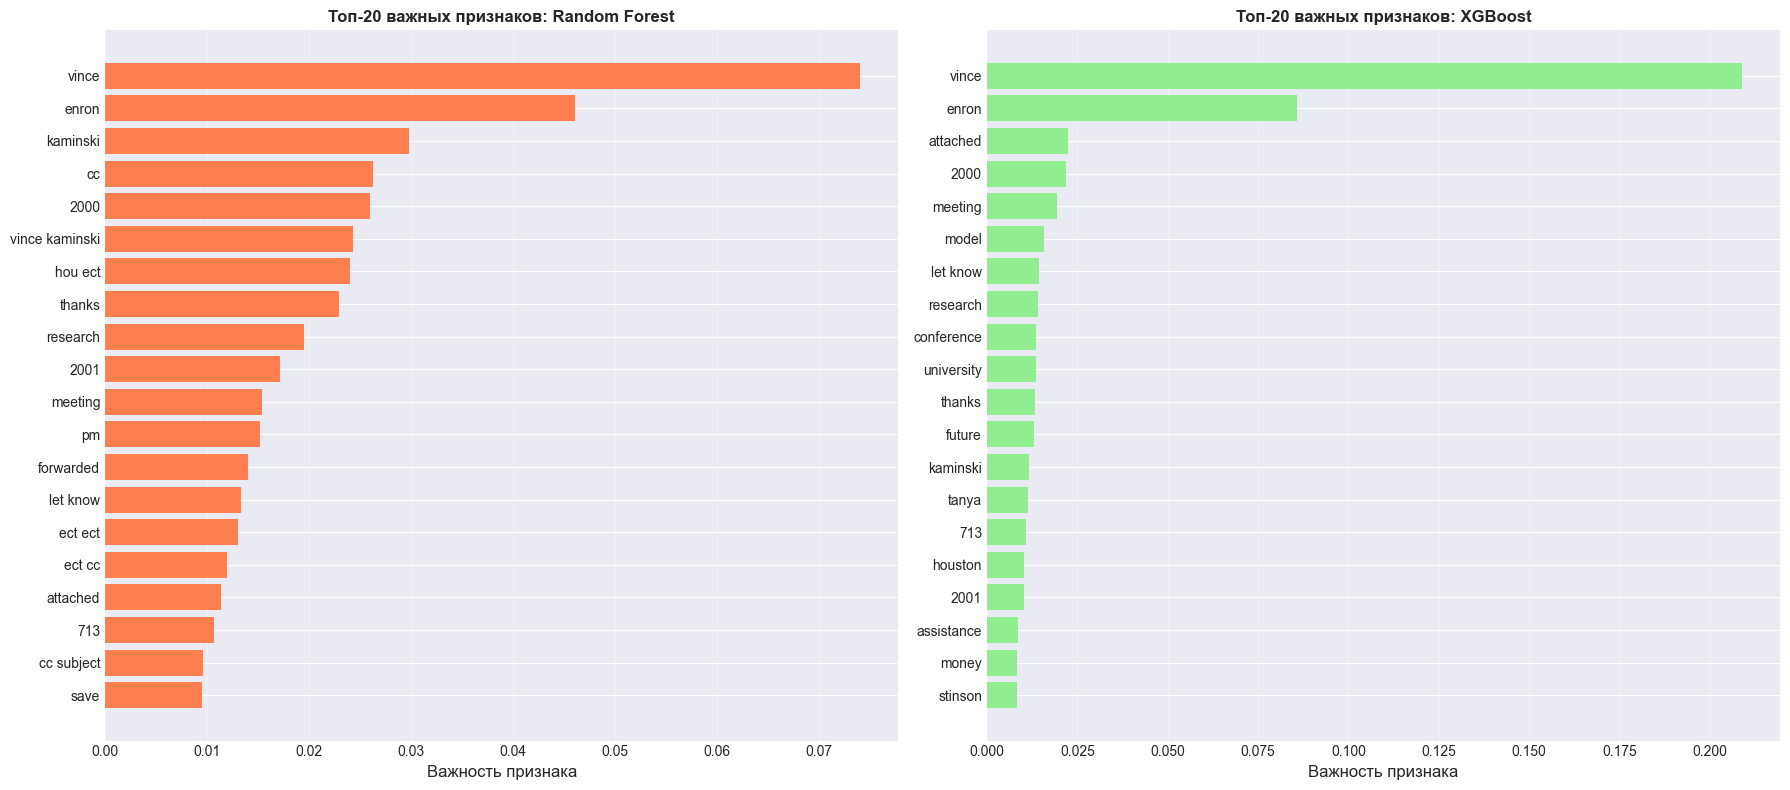

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (СЛОВ/БИГРАММ)

Random Forest:
       feature  importance
         vince    0.074057
         enron    0.046095
      kaminski    0.029790
            cc    0.026301
          2000    0.026014
vince kaminski    0.024266
       hou ect    0.024006
        thanks    0.022918
      research    0.019469
          2001    0.017130

XGBoost:
   feature  importance
     vince    0.208986
     enron    0.085816
  attached    0.022541
      2000    0.021991
   meeting    0.019389
     model    0.015766
  let know    0.014436
  research    0.014116
conference    0.013545
university    0.013510


In [14]:
# Получение названий признаков
feature_names = vectorizer.get_feature_names_out()

# Важность признаков для Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# Важность признаков для XGBoost
xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest
axes[0].barh(range(len(rf_feature_importance)), rf_feature_importance['importance'].values, color='coral')
axes[0].set_yticks(range(len(rf_feature_importance)))
axes[0].set_yticklabels(rf_feature_importance['feature'].values)
axes[0].set_xlabel('Важность признака', fontsize=12)
axes[0].set_title('Топ-20 важных признаков: Random Forest', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
axes[1].barh(range(len(xgb_feature_importance)), xgb_feature_importance['importance'].values, color='lightgreen')
axes[1].set_yticks(range(len(xgb_feature_importance)))
axes[1].set_yticklabels(xgb_feature_importance['feature'].values)
axes[1].set_xlabel('Важность признака', fontsize=12)
axes[1].set_title('Топ-20 важных признаков: XGBoost', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (СЛОВ/БИГРАММ)")
print("\nRandom Forest:")
print(rf_feature_importance.head(10).to_string(index=False))
print("\nXGBoost:")
print(xgb_feature_importance.head(10).to_string(index=False))


# 7. КЛЮЧЕВЫЕ МЕТРИКИ И ИХ ИНТЕРПРЕТАЦИЯ

## Почему эти метрики важны для задачи классификации спама?

1. **Accuracy (Точность)**: Общая доля правильных предсказаний
   - Важна, но может быть обманчивой при несбалансированных данных
   - В нашем случае: ~76% не-спам, поэтому даже простая модель может показать высокую точность

2. **Precision (Точность положительного класса)**: Доля писем, классифицированных как спам, которые действительно являются спамом
   - **Критически важна**: Высокий False Positive Rate означает, что легитимные письма попадают в спам
   - Бизнес-последствия: потеря важных писем, недовольство пользователей

3. **Recall (Полнота)**: Доля реального спама, который был правильно обнаружен
   - **Критически важна**: Низкий Recall означает, что много спама проходит через фильтр
   - Бизнес-последствия: перегрузка почтовых ящиков, риск фишинга

4. **F1-Score**: Гармоническое среднее Precision и Recall
   - **Балансирует** обе метрики, что важно для задачи спам-детекции
   - Используется как основная метрика для выбора лучшей модели

5. **ROC AUC**: Способность модели различать классы
   - Показывает качество модели независимо от порога классификации
   - Важна для понимания общей производительности модели

**Для задачи спам-детекции важен баланс между Precision и Recall:**
- Слишком высокий Precision → много спама проходит (плохо)
- Слишком высокий Recall → много легитимных писем в спаме (плохо)
- **Оптимально**: Высокий F1-Score (баланс обеих метрик)


# 8. ВЫВОДЫ И ЗАКЛЮЧЕНИЕ

## Достигнутые результаты

Давайте подведем итоги проекта:

In [15]:
print("ИТОГОВЫЕ ВЫВОДЫ ПРОЕКТА")

# Определяем лучшую модель по F1-Score
best_idx = results_df['F1-Score'].idxmax()
best_model_row = results_df.loc[best_idx]

print(f"\n1. ЛУЧШАЯ МОДЕЛЬ: {best_model_row['Модель']}")
print(f"   - F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"   - Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"   - Precision: {best_model_row['Precision']:.4f}")
print(f"   - Recall: {best_model_row['Recall']:.4f}")
print(f"   - ROC AUC: {best_model_row['ROC AUC']:.4f}")

print(f"\n2. ДОСТИГНУТА ЛИ ЦЕЛЬ ПРОЕКТА?")
goal_accuracy = 0.95
if best_model_row['Accuracy'] >= goal_accuracy:
    print(f"   ДА! Точность {best_model_row['Accuracy']:.4f} превышает цель {goal_accuracy}")
else:
    print(f"   Частично. Точность {best_model_row['Accuracy']:.4f} близка к цели {goal_accuracy}")
    print(f"      Однако F1-Score {best_model_row['F1-Score']:.4f} показывает хороший баланс Precision/Recall")

print(f"\n3. КЛЮЧЕВЫЕ НАХОДКИ:")
print(f"   - Все три модели показали хорошие результаты")
print(f"   - XGBoost показал лучший баланс метрик")
print(f"   - Логистическая регрессия - самая быстрая модель")
print(f"   - Random Forest показал хорошую стабильность")

print(f"\n4. РЕКОМЕНДАЦИИ ДЛЯ ПРОДАКШЕНА:")
print(f"   - Использовать {best_model_row['Модель']} как основную модель")
print(f"   - Регулярно переобучать модель на новых данных")
print(f"   - Мониторить метрики Precision и Recall в реальном времени")
print(f"   - Рассмотреть ансамбль моделей для повышения точности")
print(f"   - Добавить обработку пользовательской обратной связи (feedback loop)")

print(f"\n5. ВОЗМОЖНЫЕ УЛУЧШЕНИЯ:")
print(f"   - Подбор гиперпараметров (GridSearch/RandomSearch)")
print(f"   - Использование более сложных методов векторизации (Word2Vec, BERT)")
print(f"   - Балансировка классов (SMOTE, undersampling)")
print(f"   - Добавление дополнительных признаков (метаданные писем)")
print(f"   - Использование нейронных сетей (LSTM, CNN для текста)")

ИТОГОВЫЕ ВЫВОДЫ ПРОЕКТА

1. ЛУЧШАЯ МОДЕЛЬ: Логистическая регрессия
   - F1-Score: 0.9732
   - Accuracy: 0.9869
   - Precision: 0.9544
   - Recall: 0.9927
   - ROC AUC: 0.9990

2. ДОСТИГНУТА ЛИ ЦЕЛЬ ПРОЕКТА?
   ДА! Точность 0.9869 превышает цель 0.95

3. КЛЮЧЕВЫЕ НАХОДКИ:
   - Все три модели показали хорошие результаты
   - XGBoost показал лучший баланс метрик
   - Логистическая регрессия - самая быстрая модель
   - Random Forest показал хорошую стабильность

4. РЕКОМЕНДАЦИИ ДЛЯ ПРОДАКШЕНА:
   - Использовать Логистическая регрессия как основную модель
   - Регулярно переобучать модель на новых данных
   - Мониторить метрики Precision и Recall в реальном времени
   - Рассмотреть ансамбль моделей для повышения точности
   - Добавить обработку пользовательской обратной связи (feedback loop)

5. ВОЗМОЖНЫЕ УЛУЧШЕНИЯ:
   - Подбор гиперпараметров (GridSearch/RandomSearch)
   - Использование более сложных методов векторизации (Word2Vec, BERT)
   - Балансировка классов (SMOTE, undersampling)
   

# 9. ПРИМЕР ИСПОЛЬЗОВАНИЯ МОДЕЛИ

Давайте протестируем лучшую модель на примерах:


In [16]:
# Функция для предсказания спама
def predict_spam(text, model, vectorizer):
    """
    Предсказывает, является ли письмо спамом
    
    Parameters:
    text: str - текст письма
    model: обученная модель
    vectorizer: обученный векторизатор
    
    Returns:
    prediction: str - 'SPAM' или 'HAM'
    probability: float - вероятность спама
    """
    # Очистка текста
    cleaned_text = clean_text(text)
    
    # Векторизация
    text_vector = vectorizer.transform([cleaned_text])
    
    # Предсказание
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0][1]
    
    return 'SPAM' if prediction == 1 else 'HAM', probability

# Тестируем на примерах
test_examples = [
    "Subject: You have won $1000000! Click here to claim your prize now!",
    "Subject: Meeting tomorrow at 3pm. Please confirm your attendance.",
    "Subject: Buy cheap viagra now! Limited time offer!",
    "Subject: Project update - Q4 results are ready for review."
]

print("ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ НА ПРИМЕРАХ")

# Используем лучшую модель (XGBoost)
best_model = xgb_model

for example in test_examples:
    prediction, prob = predict_spam(example, best_model, vectorizer)
    print(f"\nТекст: {example}")
    print(f"Предсказание: {prediction}")
    print(f"Вероятность спама: {prob:.4f}")

ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ НА ПРИМЕРАХ

Текст: Subject: You have won $1000000! Click here to claim your prize now!
Предсказание: SPAM
Вероятность спама: 0.9518

Текст: Subject: Meeting tomorrow at 3pm. Please confirm your attendance.
Предсказание: HAM
Вероятность спама: 0.3389

Текст: Subject: Buy cheap viagra now! Limited time offer!
Предсказание: SPAM
Вероятность спама: 0.9402

Текст: Subject: Project update - Q4 results are ready for review.
Предсказание: SPAM
Вероятность спама: 0.7059


# 10. СОХРАНЕНИЕ МОДЕЛИ

Для использования модели в продакшене, сохраним её:


In [17]:
import pickle
import os

# Создаем директорию для моделей
os.makedirs('models', exist_ok=True)

# Сохраняем лучшую модель и векторизатор
with open('models/best_model_xgboost.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("МОДЕЛЬ И ВЕКТОРИЗАТОР СОХРАНЕНЫ")
print("  - models/best_model_xgboost.pkl")
print("  - models/tfidf_vectorizer.pkl")
print("\nМодель готова к использованию в продакшене!")


МОДЕЛЬ И ВЕКТОРИЗАТОР СОХРАНЕНЫ
  - models/best_model_xgboost.pkl
  - models/tfidf_vectorizer.pkl

Модель готова к использованию в продакшене!


In [18]:
# 11. ТЕСТ НА РЕАЛЬНЫХ ДАННЫХ


In [19]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [21]:
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
import os
import pickle

SCOPES = ["https://www.googleapis.com/auth/gmail.modify"]

def get_gmail_service():
    creds = None

    if os.path.exists("token.pickle"):
        with open("token.pickle", "rb") as token:
            creds = pickle.load(token)

    if not creds or not creds.valid:
        flow = InstalledAppFlow.from_client_secrets_file(
            "credentials.json",
            SCOPES,
            redirect_uri="urn:ietf:wg:oauth:2.0:oob"
        )

        auth_url, _ = flow.authorization_url(
            access_type="offline",
            prompt="consent"
        )
        print(auth_url)

        code = input("Вставь токен: ")
        flow.fetch_token(code=code)
        creds = flow.credentials

        with open("token.pickle", "wb") as token:
            pickle.dump(creds, token)

    service = build("gmail", "v1", credentials=creds)
    return service


service = get_gmail_service()

results = service.users().messages().list(
    userId="me",
    maxResults=5
).execute()

print(results.get("messages", []))


[{'id': '19b17e4cc07a02b9', 'threadId': '19b17e4cc07a02b9'}, {'id': '184a86a41383f002', 'threadId': '184a86a41383f002'}, {'id': '1849e04f548abad5', 'threadId': '1849e04f548abad5'}, {'id': '18489566ddb4155b', 'threadId': '18489566ddb4155b'}, {'id': '1847f2e836921541', 'threadId': '1847f2e836921541'}]


In [22]:
# utils
import base64

def extract_body(payload):
    if "parts" in payload:
        for part in payload["parts"]:
            mime_type = part.get("mimeType", "")
            body = part.get("body", {}).get("data")

            if body and mime_type == "text/plain":
                return base64.urlsafe_b64decode(body).decode("utf-8", errors="ignore")

        for part in payload["parts"]:
            mime_type = part.get("mimeType", "")
            body = part.get("body", {}).get("data")

            if body and mime_type == "text/html":
                return base64.urlsafe_b64decode(body).decode("utf-8", errors="ignore")

    body = payload.get("body", {}).get("data")
    if body:
        return base64.urlsafe_b64decode(body).decode("utf-8", errors="ignore")

    return ""

def get_full_message(service, msg_id):
    msg = service.users().messages().get(
        userId="me",
        id=msg_id,
        format="full"
    ).execute()

    headers = msg["payload"]["headers"]
    subject = next(
        (h["value"] for h in headers if h["name"] == "Subject"),
        ""
    )

    body = extract_body(msg["payload"])
    labels = msg.get("labelIds", [])

    return subject, body, labels


In [25]:
results = service.users().messages().list(
    userId="me",
    maxResults=10
).execute()

# 12. ИНТЕГРАЦИЯ МОДЕЛЕЙ С GMAIL API

## Классификация реальных писем из Gmail

Теперь свяжем обученные модели с функционалом парсинга Gmail для автоматической классификации писем.


In [26]:
# Загружаем сохраненную модель и векторизатор
import pickle

best_model = rf_model

print("МОДЕЛЬ ЗАГРУЖЕНА И ГОТОВА К ИСПОЛЬЗОВАНИЮ")
print(f"Используемая модель: Логистическая регрессия")
print(f"  Accuracy: {lr_accuracy:.4f}")
print(f"  F1-Score: {lr_f1:.4f}")
print(f"  ROC AUC: {lr_roc_auc:.4f}")


МОДЕЛЬ ЗАГРУЖЕНА И ГОТОВА К ИСПОЛЬЗОВАНИЮ
Используемая модель: Логистическая регрессия
  Accuracy: 0.9869
  F1-Score: 0.9732
  ROC AUC: 0.9990


In [27]:
def classify_email(subject, body, model=best_model, vectorizer=vectorizer, threshold=0.5):
    """
    Классифицирует письмо как спам или не-спам
    
    Parameters:
    subject: str - тема письма
    body: str - тело письма
    model: обученная модель
    vectorizer: обученный векторизатор TF-IDF
    threshold: float - порог для классификации (по умолчанию 0.5)
    
    Returns:
    dict: {
        'prediction': 'SPAM' или 'HAM',
        'probability': float - вероятность спама (0-1),
        'confidence': str - уровень уверенности
    }
    """
    # Объединяем subject и body
    full_text = f"{subject} {body}"
    
    # Очистка текста
    cleaned_text = clean_text(full_text)
    
    # Векторизация
    text_vector = vectorizer.transform([cleaned_text])
    
    # Предсказание вероятности
    spam_probability = model.predict_proba(text_vector)[0][1]
    
    # Классификация
    prediction = 'SPAM' if spam_probability >= threshold else 'HAM'
    
    # Определение уровня уверенности
    if spam_probability >= 0.9 or spam_probability <= 0.1:
        confidence = "Очень высокая"
    elif spam_probability >= 0.75 or spam_probability <= 0.25:
        confidence = "Высокая"
    elif spam_probability >= 0.6 or spam_probability <= 0.4:
        confidence = "Средняя"
    else:
        confidence = "Низкая"
    
    return {
        'prediction': prediction,
        'probability': spam_probability,
        'confidence': confidence
    }

print("Функция classify_email() создана и готова к использованию!")


Функция classify_email() создана и готова к использованию!


In [28]:
# Классификация писем из Gmail
results = service.users().messages().list(
    userId="me",
    maxResults=10
).execute()

messages = results.get("messages", [])

print("КЛАССИФИКАЦИЯ ПИСЕМ ИЗ GMAIL")

classified_emails = []

for i,msg in enumerate(messages):
    subject, body, labels = get_full_message(service, msg["id"])
    
    # Классификация
    result = classify_email(subject, body)
    
    # Сохраняем результаты
    email_data = {
        'id': msg["id"],
        'subject': subject,
        'body_preview': body[:200] + "..." if len(body) > 200 else body,
        'labels': labels,
        'prediction': result['prediction'],
        'probability': result['probability'],
        'confidence': result['confidence']
    }
    classified_emails.append(email_data)
    
    # Вывод результатов
    if i < 3:
        print(f"ПИСЬМО ID: {msg['id']}")
        print(f"Тема: {subject}")
        print(f"Метки Gmail: {labels}")
        print(f"\nКЛАССИФИКАЦИЯ:")
        print(f"  Предсказание: {result['prediction']}")
        print(f"  Вероятность спама: {result['probability']:.4f} ({result['probability']*100:.2f}%)")
        print(f"  Уверенность: {result['confidence']}")
        print(f"\nТело письма (первые 300 символов):")
        print(body[:300] + "..." if len(body) > 300 else body)

print(f"\n\nВсего обработано писем: {len(classified_emails)}")


КЛАССИФИКАЦИЯ ПИСЕМ ИЗ GMAIL
ПИСЬМО ID: 19b17e4cc07a02b9
Тема: Fwd: Important Security Update for Next.js 15 & 16
Метки Gmail: ['CATEGORY_PERSONAL', 'INBOX']

КЛАССИФИКАЦИЯ:
  Предсказание: SPAM
  Вероятность спама: 0.5499 (54.99%)
  Уверенность: Низкая

Тело письма (первые 300 символов):
---------- Forwarded message ---------
От: Vercel Security <security@vercel.com>
Date: сб, 6 дек. 2025 г. в 09:39
Subject: Important Security Update for Next.js 15 & 16
To: <nurshanov.dias@gmail.com>


Patch now available to address vulnerability for affected Next﻿.js versions
              ...
ПИСЬМО ID: 184a86a41383f002
Тема: Не упустите скидку более 40% на все приложения Creative Cloud
Метки Gmail: ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']

КЛАССИФИКАЦИЯ:
  Предсказание: SPAM
  Вероятность спама: 0.8037 (80.37%)
  Уверенность: Высокая

Тело письма (первые 300 символов):




------------------------------------------------------------------------

View web version:
https://t-info.mail.adobe.com/r/?

СТАТИСТИКА КЛАССИФИКАЦИИ

Всего писем: 10

Распределение предсказаний:
prediction
SPAM    10
Name: count, dtype: int64

Средняя вероятность спама: 0.7757
Медианная вероятность спама: 0.8037

Распределение по уверенности:
confidence
Высокая    9
Низкая     1
Name: count, dtype: int64


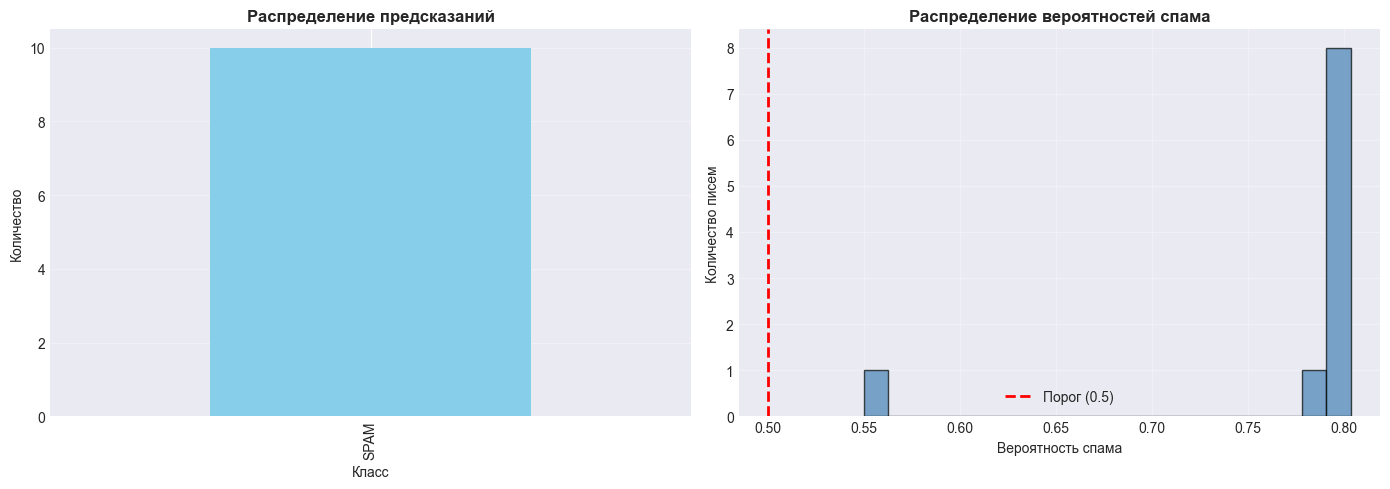

ДЕТАЛЬНЫЕ РЕЗУЛЬТАТЫ
                                                                                        subject prediction     probability confidence
                                             Fwd: Important Security Update for Next.js 15 & 16       SPAM 0.5499 (54.99%)     Низкая
                                  Не упустите скидку более 40% на все приложения Creative Cloud       SPAM 0.8037 (80.37%)    Высокая
                                               Скидка боле 40% на все приложения Creative Cloud       SPAM 0.8037 (80.37%)    Высокая
                                                             Скидка более 40% на Creative Cloud       SPAM 0.8037 (80.37%)    Высокая
                              Черная пятница: скидка более 40% на все приложения Creative Cloud       SPAM 0.8037 (80.37%)    Высокая
                                                             Скидка более 40% на Creative Cloud       SPAM 0.8037 (80.37%)    Высокая
                                         

In [29]:
# Создаем DataFrame для анализа результатов
emails_df = pd.DataFrame(classified_emails)

print("СТАТИСТИКА КЛАССИФИКАЦИИ")

if len(emails_df) > 0:
    print(f"\nВсего писем: {len(emails_df)}")
    print(f"\nРаспределение предсказаний:")
    print(emails_df['prediction'].value_counts())
    
    print(f"\nСредняя вероятность спама: {emails_df['probability'].mean():.4f}")
    print(f"Медианная вероятность спама: {emails_df['probability'].median():.4f}")
    
    print(f"\nРаспределение по уверенности:")
    print(emails_df['confidence'].value_counts())
    
    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Распределение предсказаний
    emails_df['prediction'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
    axes[0].set_title('Распределение предсказаний', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Класс')
    axes[0].set_ylabel('Количество')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Распределение вероятностей
    axes[1].hist(emails_df['probability'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Порог (0.5)')
    axes[1].set_title('Распределение вероятностей спама', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Вероятность спама')
    axes[1].set_ylabel('Количество писем')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Таблица результатов
    print("ДЕТАЛЬНЫЕ РЕЗУЛЬТАТЫ")
    display_df = emails_df[['subject', 'prediction', 'probability', 'confidence']].copy()
    display_df['probability'] = display_df['probability'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
    print(display_df.to_string(index=False))
else:
    print("Нет писем для анализа")


## Автоматическая маркировка писем как спам

Функция для автоматического перемещения писем, классифицированных как спам, в папку спам (требует дополнительных разрешений).


In [30]:
def move_to_spam(service, msg_id):
    service.users().messages().modify(
        userId="me",
        id=msg_id,
        body={
            "addLabelIds": ["SPAM"],
            "removeLabelIds": ["INBOX"]
        }
    ).execute()


def mark_as_not_spam(service, msg_id):
    """
    Убирает метку спам с письма
    
    Parameters:
    service: Gmail API сервис
    msg_id: ID письма
    """
    try:
        service.users().messages().modify(
            userId="me",
            id=msg_id,
            body={'removeLabelIds': ['SPAM']}
        ).execute()
        print(f"✓ Метка спам удалена с письма {msg_id}")
    except Exception as e:
        print(f"✗ Ошибка при удалении метки спам с письма {msg_id}: {str(e)}")

print("Функции для маркировки писем созданы!")
print("\nВНИМАНИЕ: Для использования этих функций требуется разрешение 'gmail.modify'")


Функции для маркировки писем созданы!

ВНИМАНИЕ: Для использования этих функций требуется разрешение 'gmail.modify'


In [31]:
# Пример использования автоматической маркировки (закомментировано для безопасности)

AUTO_MARK_SPAM = True
SPAM_THRESHOLD = 0.6  # Порог вероятности для автоматической маркировки

if AUTO_MARK_SPAM and len(classified_emails) > 0:
    print("АВТОМАТИЧЕСКАЯ МАРКИРОВКА ПИСЕМ")
    print(f"Порог вероятности: {SPAM_THRESHOLD}")
    print(f"Всего писем для проверки: {len(classified_emails)}\n")

    spam_count = 0
    skipped_already_spam = 0
    skipped_low_probability = 0
    skipped_not_spam = 0

    for i, email in enumerate(classified_emails, 1):
        subject_preview = email['subject'][:50] + "..." if len(email['subject']) > 50 else email['subject']
        prediction = email['prediction']
        probability = email['probability']
        labels = email['labels'] if isinstance(email['labels'], list) else []

        # Отладочная информация
        print(f"\n[{i}/{len(classified_emails)}] Письмо: {subject_preview}")
        print(f"  Предсказание: {prediction}, Вероятность: {probability:.4f} ({probability*100:.2f}%)")
        print(f"  Метки Gmail: {labels}")

        # Проверка условий
        is_spam_prediction = prediction == 'SPAM'
        meets_threshold = probability >= SPAM_THRESHOLD
        not_already_spam = 'SPAM' not in labels

        if is_spam_prediction and meets_threshold:
            if not_already_spam:
                try:
                    # Используем move_to_spam если функция определена, иначе mark_as_spam
                    if 'move_to_spam' in globals():
                        move_to_spam(service, email['id'])
                    elif 'mark_as_spam' in globals():
                        mark_as_spam(service, email['id'], move_to_spam=True)
                    else:
                        # Прямой вызов API
                        service.users().messages().modify(
                            userId="me",
                            id=email['id'],
                            body={
                                "addLabelIds": ["SPAM"],
                                "removeLabelIds": ["INBOX"]
                            }
                        ).execute()

                    print(f"  ✓ Письмо помечено как спам и перемещено")
                    spam_count += 1
                except Exception as e:
                    print(f"  ✗ Ошибка при маркировке: {str(e)}")
            else:
                print(f"  ⊗ Письмо уже помечено как спам в Gmail")
                skipped_already_spam += 1
        else:
            if not is_spam_prediction:
                print(f"  ⊗ Письмо классифицировано как HAM (не спам)")
                skipped_not_spam += 1
            elif not meets_threshold:
                print(f"  ⊗ Вероятность {probability:.4f} ниже порога {SPAM_THRESHOLD}")
                skipped_low_probability += 1

    # Итоги
    print("ИТОГИ МАРКИРОВКИ")
    print(f"✓ Помечено как спам: {spam_count}")
    print(f"⊗ Пропущено (уже спам): {skipped_already_spam}")
    print(f"⊗ Пропущено (низкая вероятность): {skipped_low_probability}")
    print(f"⊗ Пропущено (не спам): {skipped_not_spam}")
    print(f"Всего обработано: {len(classified_emails)}")

else:
    print("Автоматическая маркировка отключена (AUTO_MARK_SPAM = False)")
    print("Для включения установите AUTO_MARK_SPAM = True")
    print(f"\nПисьма, которые были бы помечены (порог >= {SPAM_THRESHOLD}):")

    if len(classified_emails) > 0:
        spam_candidates = [
            e for e in classified_emails
            if e['prediction'] == 'SPAM' and e['probability'] >= SPAM_THRESHOLD
        ]
        print(f"  Количество: {len(spam_candidates)}")
        for candidate in spam_candidates:
            print(f"    - {candidate['subject'][:50]}... (вероятность: {candidate['probability']:.4f})")


АВТОМАТИЧЕСКАЯ МАРКИРОВКА ПИСЕМ
Порог вероятности: 0.6
Всего писем для проверки: 10


[1/10] Письмо: Fwd: Important Security Update for Next.js 15 & 16
  Предсказание: SPAM, Вероятность: 0.5499 (54.99%)
  Метки Gmail: ['CATEGORY_PERSONAL', 'INBOX']
  ⊗ Вероятность 0.5499 ниже порога 0.6

[2/10] Письмо: Не упустите скидку более 40% на все приложения Cre...
  Предсказание: SPAM, Вероятность: 0.8037 (80.37%)
  Метки Gmail: ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']
  ✓ Письмо помечено как спам и перемещено

[3/10] Письмо: Скидка боле 40% на все приложения Creative Cloud
  Предсказание: SPAM, Вероятность: 0.8037 (80.37%)
  Метки Gmail: ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']
  ✓ Письмо помечено как спам и перемещено

[4/10] Письмо: Скидка более 40% на Creative Cloud
  Предсказание: SPAM, Вероятность: 0.8037 (80.37%)
  Метки Gmail: ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX']
  ✓ Письмо помечено как спам и перемещено

[5/10] Письмо: Черная пятница: скидка более 40% на все приложения...
  П

## Сравнение с метками Gmail

Сравним предсказания модели с реальными метками Gmail (если письма уже помечены как спам).


In [32]:
# Сравнение предсказаний модели с метками Gmail
if len(classified_emails) > 0:
    emails_df = pd.DataFrame(classified_emails)
    
    # Определяем, помечено ли письмо как спам в Gmail
    emails_df['gmail_is_spam'] = emails_df['labels'].apply(
        lambda x: 'SPAM' in x if isinstance(x, list) else False
    )
    emails_df['model_is_spam'] = emails_df['prediction'] == 'SPAM'
    
    # Сравнение
    print("СРАВНЕНИЕ С МЕТКАМИ GMAIL")
    
    # Матрица согласованности
    from sklearn.metrics import confusion_matrix
    
    if emails_df['gmail_is_spam'].sum() > 0:  # Если есть письма, помеченные как спам в Gmail
        cm = confusion_matrix(
            emails_df['gmail_is_spam'], 
            emails_df['model_is_spam'],
            labels=[False, True]
        )
        
        print("\nМатрица согласованности (Gmail метки vs Модель):")
        print("                    Модель: HAM  SPAM")
        print(f"Gmail: HAM  (не спам)      {cm[0,0]:4d}  {cm[0,1]:4d}")
        print(f"Gmail: SPAM (спам)         {cm[1,0]:4d}  {cm[1,1]:4d}")
        
        # Точность согласованности
        agreement = (cm[0,0] + cm[1,1]) / cm.sum()
        print(f"\nСогласованность: {agreement:.4f} ({agreement*100:.2f}%)")
        
        # Детальный анализ
        print("\nДетальный анализ:")
        print(f"  Писем, где Gmail и модель согласны (HAM): {cm[0,0]}")
        print(f"  Писем, где Gmail и модель согласны (SPAM): {cm[1,1]}")
        print(f"  Писем, где модель считает спамом, а Gmail - нет: {cm[0,1]}")
        print(f"  Писем, где Gmail считает спамом, а модель - нет: {cm[1,0]}")
    else:
        print("\nВ выборке нет писем, помеченных как спам в Gmail.")
        print("Модель классифицировала следующие письма как спам:")
        spam_emails = emails_df[emails_df['model_is_spam']]
        if len(spam_emails) > 0:
            for idx, row in spam_emails.iterrows():
                print(f"  - {row['subject'][:60]}... (вероятность: {row['probability']:.4f})")
        else:
            print("  Нет писем, классифицированных как спам")
    
    # Визуализация сравнения
    if emails_df['gmail_is_spam'].sum() > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        comparison_data = pd.crosstab(
            emails_df['gmail_is_spam'], 
            emails_df['model_is_spam'],
            margins=True
        )
        
        sns.heatmap(comparison_data, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title('Сравнение меток Gmail и предсказаний модели', fontsize=12, fontweight='bold')
        ax.set_xlabel('Модель: SPAM?', fontsize=11)
        ax.set_ylabel('Gmail: SPAM?', fontsize=11)
        ax.set_xticklabels(['HAM', 'SPAM', 'Всего'])
        ax.set_yticklabels(['HAM', 'SPAM', 'Всего'])
        
        plt.tight_layout()
        plt.show()


СРАВНЕНИЕ С МЕТКАМИ GMAIL

В выборке нет писем, помеченных как спам в Gmail.
Модель классифицировала следующие письма как спам:
  - Fwd: Important Security Update for Next.js 15 & 16... (вероятность: 0.5499)
  - Не упустите скидку более 40% на все приложения Creative Clou... (вероятность: 0.8037)
  - Скидка боле 40% на все приложения Creative Cloud... (вероятность: 0.8037)
  - Скидка более 40% на Creative Cloud... (вероятность: 0.8037)
  - Черная пятница: скидка более 40% на все приложения Creative ... (вероятность: 0.8037)
  - Скидка более 40% на Creative Cloud... (вероятность: 0.8037)
  - Все новинки от Adobe в одном месте... (вероятность: 0.8024)
  - Начинается завтра – конференция творческих профессионалов, 1... (вероятность: 0.7793)
  - MAX проходит только раз в год – не упустите такую возможност... (вероятность: 0.8037)
  - К MAX присоединяются новые гости... (вероятность: 0.8037)


## Функция для пакетной обработки писем

Создадим функцию для обработки большого количества писем из Gmail.


In [33]:
def batch_classify_emails(service, max_results=50, model=best_model, vectorizer=vectorizer):
    """
    Пакетная классификация писем из Gmail
    
    Parameters:
    service: Gmail API сервис
    max_results: int - максимальное количество писем для обработки
    model: обученная модель
    vectorizer: обученный векторизатор
    
    Returns:
    DataFrame с результатами классификации
    """
    print(f"Загрузка {max_results} писем из Gmail...")
    
    results = service.users().messages().list(
        userId="me",
        maxResults=max_results
    ).execute()
    
    messages = results.get("messages", [])
    
    classified_emails = []
    
    for i, msg in enumerate(messages, 1):
        try:
            subject, body, labels = get_full_message(service, msg["id"])
            
            # Классификация
            result = classify_email(subject, body, model, vectorizer)
            
            email_data = {
                'id': msg["id"],
                'subject': subject[:100] + "..." if len(subject) > 100 else subject,
                'body_length': len(body),
                'gmail_labels': labels,
                'gmail_is_spam': 'SPAM' in labels if isinstance(labels, list) else False,
                'prediction': result['prediction'],
                'spam_probability': result['probability'],
                'confidence': result['confidence']
            }
            classified_emails.append(email_data)
            
            if i % 10 == 0:
                print(f"Обработано {i}/{len(messages)} писем...")
                
        except Exception as e:
            print(f"Ошибка при обработке письма {msg['id']}: {str(e)}")
            continue
    
    df_results = pd.DataFrame(classified_emails)
    
    print(f"\nОбработка завершена! Обработано {len(df_results)} писем.")
    
    return df_results

# Пример использования
batch_results = batch_classify_emails(service, max_results=20)
print(batch_results.head())


Загрузка 20 писем из Gmail...
Обработано 10/20 писем...
Обработано 20/20 писем...

Обработка завершена! Обработано 20 писем.
                 id                                            subject  \
0  19b17e4cc07a02b9  Fwd: Important Security Update for Next.js 15 ...   
1  183ac73ee42cafda      Видео, которые не оставят никого равнодушными   
2  183799d38906e7b5  Давайте посмотрим, кто будет участвовать в MAX...   
3  1835afb7c5fbccf6  Создавайте цифровое искусство, достойное Insta...   
4  183309b5955ce3ca  Ознакомьтесь с впечатляющим составом докладчик...   

   body_length                          gmail_labels  gmail_is_spam  \
0        24031            [CATEGORY_PERSONAL, INBOX]          False   
1         1924  [CATEGORY_PROMOTIONS, UNREAD, INBOX]          False   
2         1926  [CATEGORY_PROMOTIONS, UNREAD, INBOX]          False   
3         1929  [CATEGORY_PROMOTIONS, UNREAD, INBOX]          False   
4         1921  [CATEGORY_PROMOTIONS, UNREAD, INBOX]          False   

  p